<a href="https://colab.research.google.com/github/ayselrajabli/Time-Series-Analysis--FbProphet/blob/main/FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

In [45]:
import pandas as pd
import numpy as np
import itertools
from fbprophet import Prophet
from statsmodels.base.transform import BoxCox
from fbprophet.diagnostics import cross_validation,performance_metrics

In [28]:
url = 'https://raw.githubusercontent.com/ayselrajabli/Time-Series-Analysis--FbProphet/main/google-data.csv'

In [29]:
df = pd.read_csv(url, encoding = 'unicode_escape')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1259.0,6.527041e+02,1.756306e+02,350.053253,5.282871e+02,6.000026e+02,7.740150e+02,1.075200e+03
High,1259.0,6.574757e+02,1.766274e+02,350.391052,5.326152e+02,6.032365e+02,7.791200e+02,1.078490e+03
Low,1259.0,6.474337e+02,1.747328e+02,345.512787,5.242325e+02,5.944537e+02,7.686625e+02,1.063550e+03
Close,1259.0,6.526570e+02,1.758210e+02,349.164032,5.284294e+02,5.980056e+02,7.727200e+02,1.077140e+03
Adj Close,1259.0,6.526570e+02,1.758210e+02,349.164032,5.284294e+02,5.980056e+02,7.727200e+02,1.077140e+03
Volume,1259.0,2.414928e+06,1.672160e+06,7900.000000,1.336900e+06,1.842300e+06,3.090850e+06,2.328310e+07


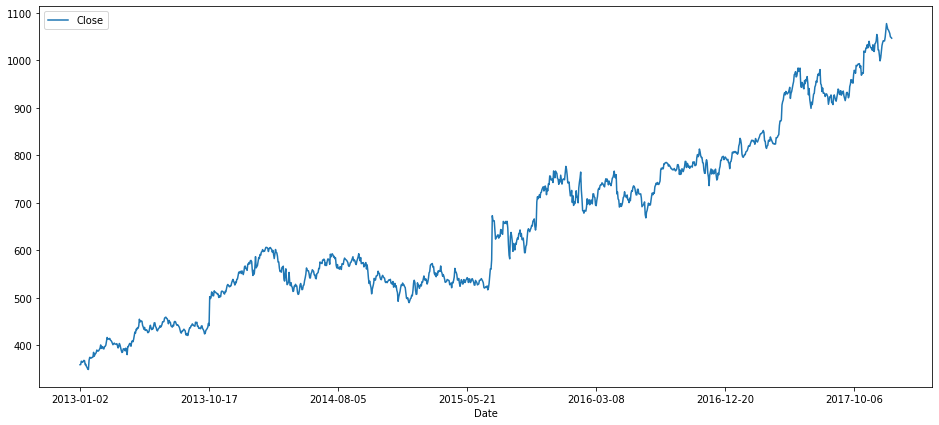

In [31]:
df.plot(x='Date',y='Close',figsize=(16,7))

In [32]:
bc=BoxCox()

In [33]:
df['Close'], lmbda=bc.transform_boxcox(df['Close'])

In [37]:
data=df[["Date","Close"]]
data.columns=["ds","y"]


In [38]:
model_params={
    "daily_seasonality":False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "seasonality_mode": "multiplicative",
    "growth": "logistic"
}

In [39]:
model=Prophet(**model_params)
data["cap"]=data['y'].max() + data['y'].std()*0.05
model.fit(data)
future=model.make_future_dataframe(periods=365)
future["cap"]=data["cap"].max()
forecast=model.predict(future)

<ipython-input-39-c45b7b5370e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cap"]=data['y'].max() + data['y'].std()*0.05


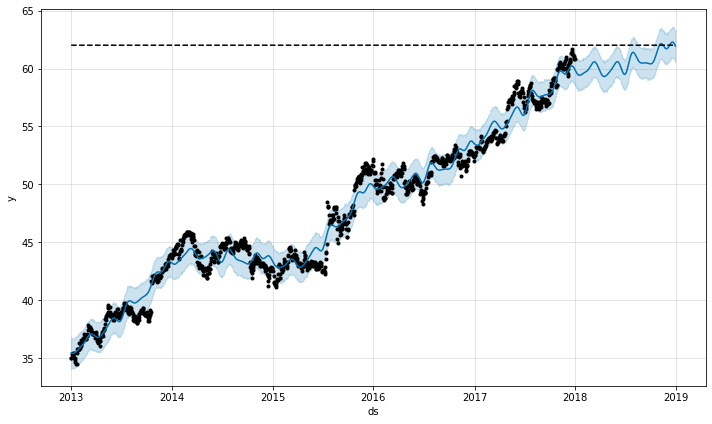

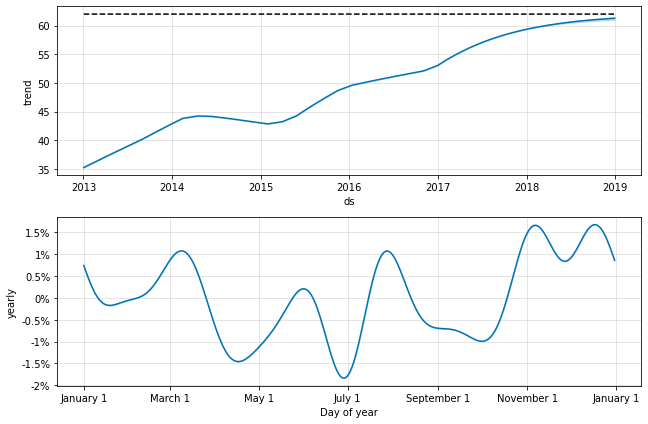

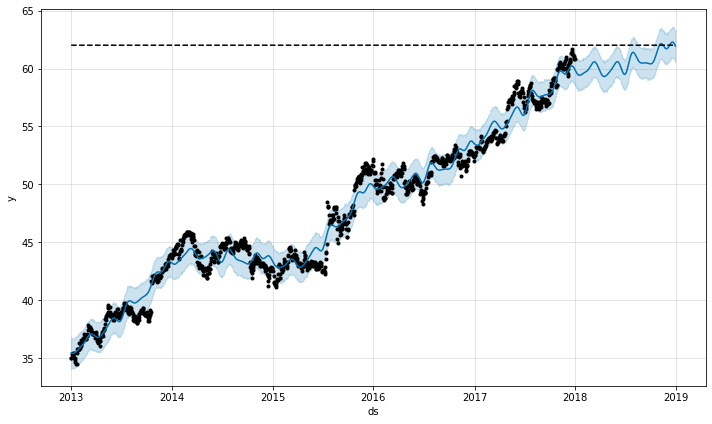

In [40]:
model.plot_components(forecast)
model.plot(forecast)

In [41]:
model=Prophet(**model_params)
model.add_seasonality(name="monthly",period=30,fourier_order=10)
model.add_seasonality(name="quaterly",period=92.95,fourier_order=10)
model.add_country_holidays("US")
model.fit(data)
future=model.make_future_dataframe(periods=365)
future["cap"]=data["cap"].max()
forecast=model.predict(future)

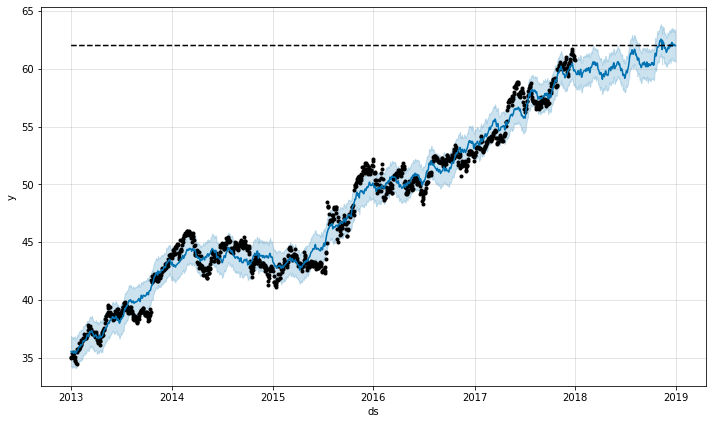

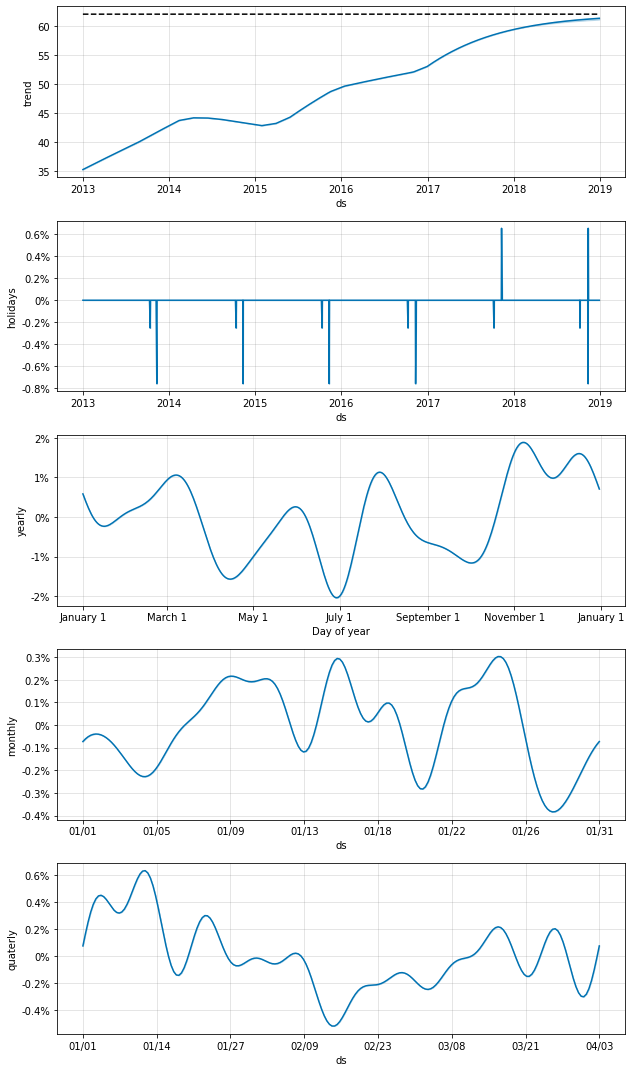

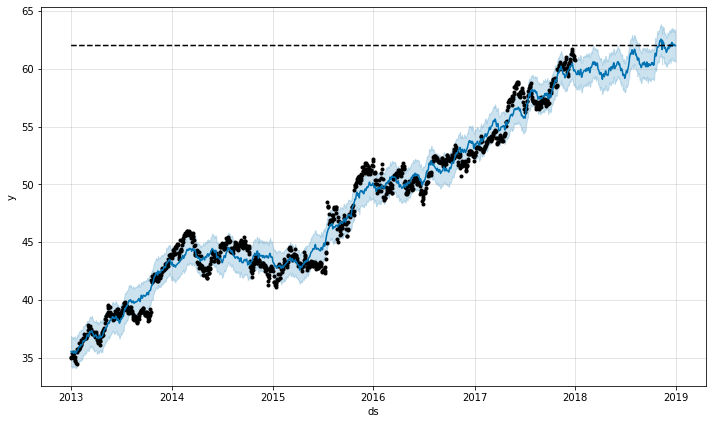

In [43]:
model.plot_components(forecast)
model.plot(forecast)

In [46]:
param_grid={
    "daily_seasonality":[False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [True],
    "growth": ["logistic"],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]

}

In [47]:
all_params=[
            dict(zip(param_grid.keys(),v))
            for v in itertools.product(*param_grid.values())
]

In [48]:
all_params

[{'daily_seasonality': False,
  'weekly_seasonality': False,
  'yearly_seasonality': True,
  'growth': 'logistic',
  'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01},
 {'daily_seasonality': False,
  'weekly_seasonality': False,
  'yearly_seasonality': True,
  'growth': 'logistic',
  'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.1},
 {'daily_seasonality': False,
  'weekly_seasonality': False,
  'yearly_seasonality': True,
  'growth': 'logistic',
  'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 1.0},
 {'daily_seasonality': False,
  'weekly_seasonality': False,
  'yearly_seasonality': True,
  'growth': 'logistic',
  'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0},
 {'daily_seasonality': False,
  'weekly_seasonality': False,
  'yearly_seasonality': True,
  'growth': 'logistic',
  'changepoint_prior_scale': 0.01,
  'seasonality_prior_scale': 0.01},
 {'daily_seasonality': False,
  'weekly_seasonality': False,
  'year

In [49]:
rmses=list()

for params in all_params:
  m=Prophet(**params)
  m=m.add_seasonality(name="monthly",period=30,fourier_order=5)
  m=m.add_seasonality(name="quaterly",period=92.25,fourier_order=10)
  m.add_country_holidays(country_name="US")
  m.fit(data)
  df_cv=cross_validation(m,initial="730 days",period="365 days", horizon="365 days",parallel="processes")
  df_p=performance_metrics(df_cv,rolling_window=1)
  rmses.append(df_p['rmse'].values[0])

  best_params=all_params[np.argmin(rmses)]
  print("\nThe best params are:",best_params)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec66a2850>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec6749d60>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec68741c0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec66a2af0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec6804ee0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec6874f40>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec67a6f40>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec66a2c70>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec677e9d0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec675e0a0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec67a8b50>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec67fdb20>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec6763ee0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec66fa2b0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec67fd100>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Making 2 forecasts with cutoffs between 2015-12-30 00:00:00 and 2016-12-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcec677e8b0>



The best params are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [50]:
best_model=Prophet(**best_params)
best_model=best_model.add_seasonality(name="monthly",period=30,fourier_order=5)
best_model=best_model.add_seasonality(name="quaterl",period=92.25,fourier_order=10)
best_model.add_country_holidays(country_name="US")
best_model.fit(data)
future=best_model.make_future_dataframe(periods=365,freq='D')
future["cap"]=data["cap"].max()
forecast=best_model.predict(future)

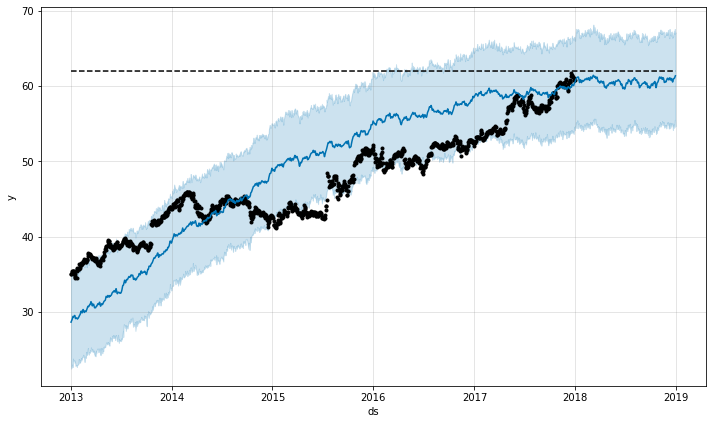

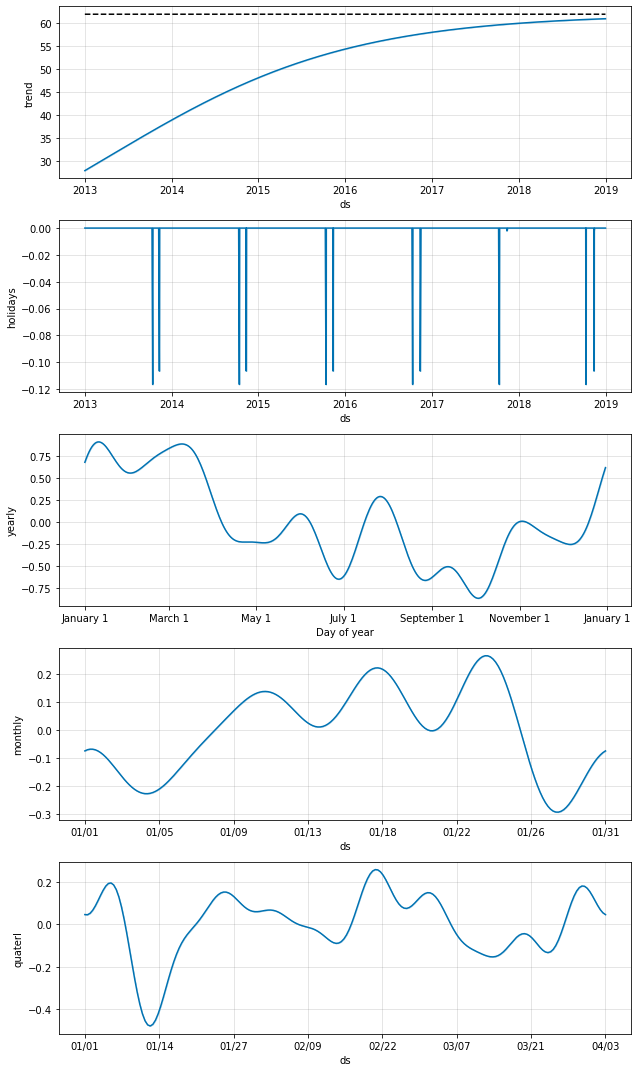

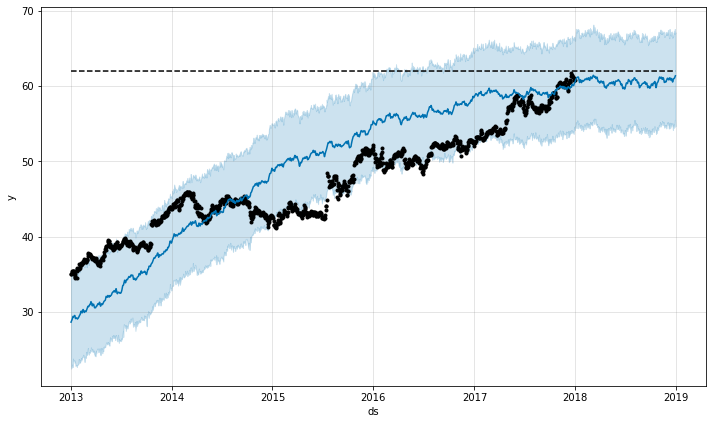

In [51]:
best_model.plot_components(forecast)
best_model.plot(forecast)

In [52]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 68 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   ds                                 1624 non-null   datetime64[ns]
 1   trend                              1624 non-null   float64       
 2   cap                                1624 non-null   float64       
 3   yhat_lower                         1624 non-null   float64       
 4   yhat_upper                         1624 non-null   float64       
 5   trend_lower                        1624 non-null   float64       
 6   trend_upper                        1624 non-null   float64       
 7   Christmas Day                      1624 non-null   float64       
 8   Christmas Day_lower                1624 non-null   float64       
 9   Christmas Day_upper                1624 non-null   float64       
 10  Christmas Day (Observed)           1

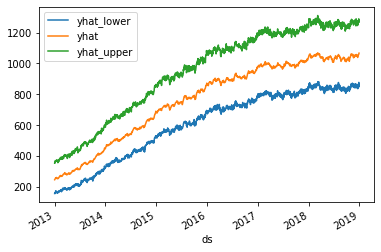

In [53]:
forecast['yhat']=bc.untransform_boxcox(x=forecast['yhat'],lmbda=lmbda)
forecast['yhat_lower']=bc.untransform_boxcox(x=forecast['yhat_lower'],lmbda=lmbda)
forecast['yhat_upper']=bc.untransform_boxcox(x=forecast['yhat_upper'],lmbda=lmbda)
forecast.plot(x='ds',y=['yhat_lower','yhat','yhat_upper'])